In [169]:
from sqlalchemy import create_engine

ADDR="10.114.22.20"
PORT=55432
USERNAME="postgres"
PASSWORD="postgres"
DBNAME="postgres"

ALGO_NAMES = [
    "dfuzzystream",
    "sfcm",
    "fcm",
    "umicro"
]

ALGO_TRAIN_PREFIX="train_without_history_270620_"
ALGO_TEST_PREFIX="test_without_history_270620_"

ALGORITHM = ALGO_NAMES[1]



TRAIN_ALGORITHM_PREFIX_NAME=f"{ALGO_TRAIN_PREFIX}{ALGORITHM}"
TRAIN_POINT_TABLE=f"{TRAIN_ALGORITHM_PREFIX_NAME}_points"
TRAIN_CLUSTER_TABLE=f"{TRAIN_ALGORITHM_PREFIX_NAME}_clusters"
TRAIN_PREDICTION_TABLE=f"{TRAIN_ALGORITHM_PREFIX_NAME}_predict"


TEST_ALGORITHM_PREFIX_NAME=f"{ALGO_TEST_PREFIX}{ALGORITHM}"
TEST_POINT_TABLE=f"{TEST_ALGORITHM_PREFIX_NAME}_points"
TEST_CLUSTER_TABLE=f"{TEST_ALGORITHM_PREFIX_NAME}_clusters"
TEST_PREDICTION_TABLE=f"{TEST_ALGORITHM_PREFIX_NAME}_predict"

engine = create_engine(f"postgresql://{USERNAME}:{PASSWORD}@{ADDR}:{PORT}/{DBNAME}")

In [170]:
#Use timestampts to save results
import datetime
current_time = datetime.date.today()

In [171]:
## Read data

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation


df_train_origin = pd.read_sql_query(f"""
SELECT {TRAIN_PREDICTION_TABLE}.timestamp, data_point, {TRAIN_PREDICTION_TABLE}.cluster_label, data_point_membership, centroid FROM
              {TRAIN_PREDICTION_TABLE} join {TRAIN_CLUSTER_TABLE}
                  on {TRAIN_PREDICTION_TABLE}.timestamp = {TRAIN_CLUSTER_TABLE}.timestamp and
                     {TRAIN_PREDICTION_TABLE}.cluster_label = {TRAIN_CLUSTER_TABLE}.unique_label""", engine)



df_test_origin = pd.read_sql_query(f"""
SELECT {TEST_PREDICTION_TABLE}.timestamp, data_point, {TEST_PREDICTION_TABLE}.cluster_label, data_point_membership, centroid FROM
              {TEST_PREDICTION_TABLE} join {TEST_CLUSTER_TABLE}
                  on {TEST_PREDICTION_TABLE}.timestamp = {TEST_CLUSTER_TABLE}.timestamp and
                     {TEST_PREDICTION_TABLE}.cluster_label = {TEST_CLUSTER_TABLE}.unique_label""", engine)



In [172]:
df_train = df_train_origin.copy()
df_test = df_test_origin.copy()


In [173]:
# FOR TRAIN DATA
#transform timestamp from string into correct format
df_train["timestamp"] = df_train["timestamp"].apply(lambda x: pd.Timestamp(x))
 
# transform data_point and centroid into numpy arrays
casted_data_points = df_train["data_point"].apply(lambda x: np.array(x))
df_train["data_point"] = casted_data_points

# add has for data points
df_train["data_point_unique_id"] = df_train["data_point"].apply(str)

casted_centroids = df_train["centroid"].apply(lambda x: np.array(x))
df_train["centroid"] = casted_centroids



# FOR TEST DATA
#transform timestamp from string into correct format
df_test["timestamp"] = df_test["timestamp"].apply(lambda x: pd.Timestamp(x))
 
# transform data_point and centroid into numpy arrays
casted_data_points = df_test["data_point"].apply(lambda x: np.array(x))
df_test["data_point"] = casted_data_points

# add has for data points
df_test["data_point_unique_id"] = df_test["data_point"].apply(str)

casted_centroids = df_test["centroid"].apply(lambda x: np.array(x))
df_test["centroid"] = casted_centroids


In [174]:
# set timestamp as index by default

df_train = df_train.set_index("timestamp")
df_test = df_test.set_index("timestamp")



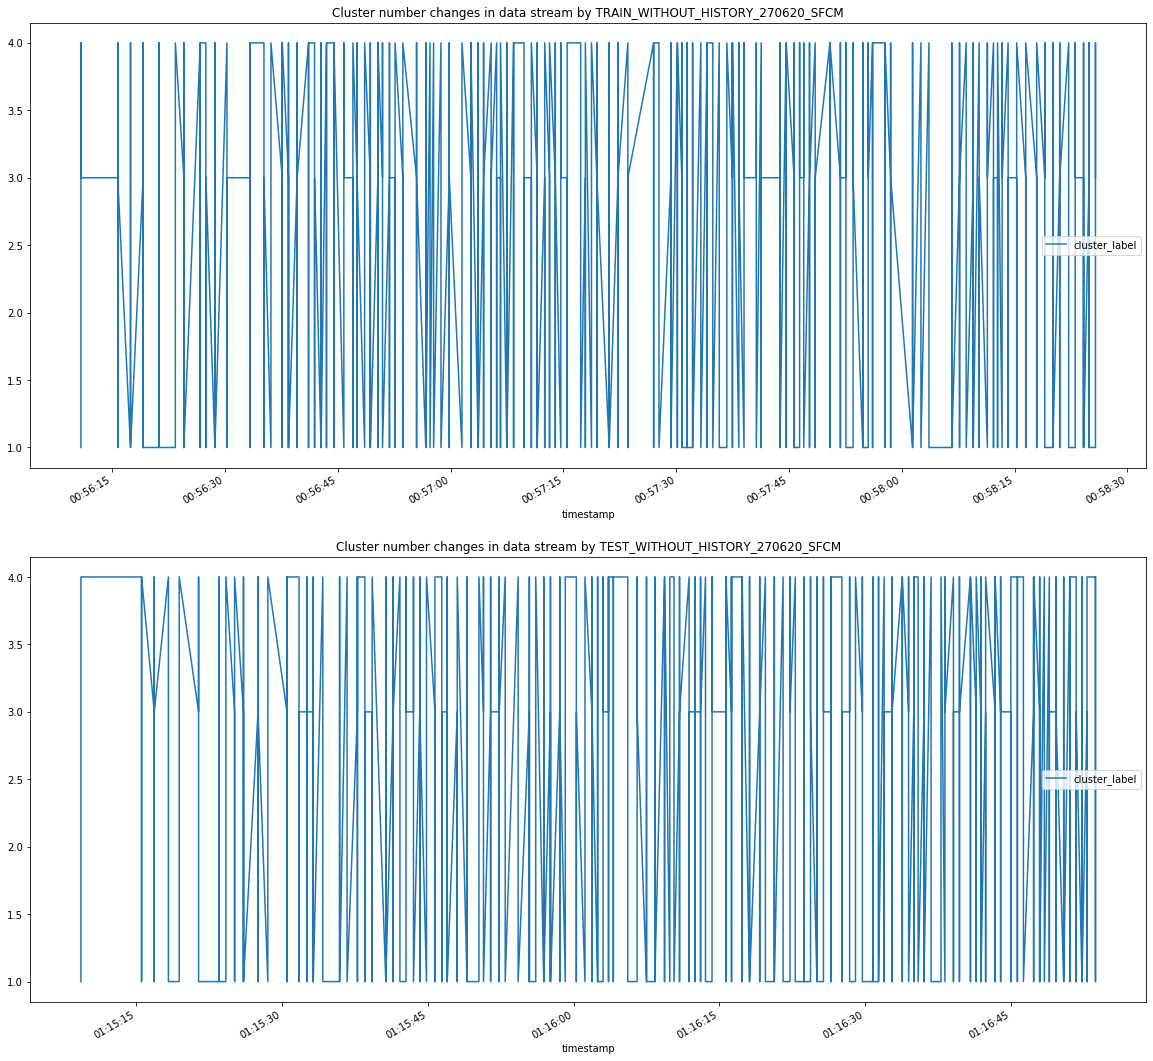

In [175]:
# Changes in number of cluster across time range

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,20))

df_train[["cluster_label"]].plot(y="cluster_label", ax=ax[0], title=f"Cluster number changes in data stream by {TRAIN_ALGORITHM_PREFIX_NAME.upper()}");
df_test[["cluster_label"]].plot(y="cluster_label", ax=ax[1], title=f"Cluster number changes in data stream by {TEST_ALGORITHM_PREFIX_NAME.upper()}");



In [176]:
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_cluster_number_changes_{current_time}.pdf")
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_cluster_number_changesa_{current_time}.png")

## Draw Data Stream


In [177]:
# The following code is required in case
# If you want to bind the color of points with its timestamp
train_cmap = mpl.cm.get_cmap('YlGn_r')
test_cmap = mpl.cm.get_cmap('YlOrRd_r')

train_timestamp_enum = dict(map(lambda x: (x[1], x[0]),enumerate(set(df_train.reset_index()["timestamp"]))))
train_time_normalizer = mpl.colors.Normalize(vmin=min(train_timestamp_enum.values()), vmax=max(train_timestamp_enum.values()))


test_timestamp_enum = dict(map(lambda x: (x[1], x[0]),enumerate(set(df_test.reset_index()["timestamp"]))))
test_time_normalizer = mpl.colors.Normalize(vmin=min(test_timestamp_enum.values()), vmax=max(test_timestamp_enum.values()))

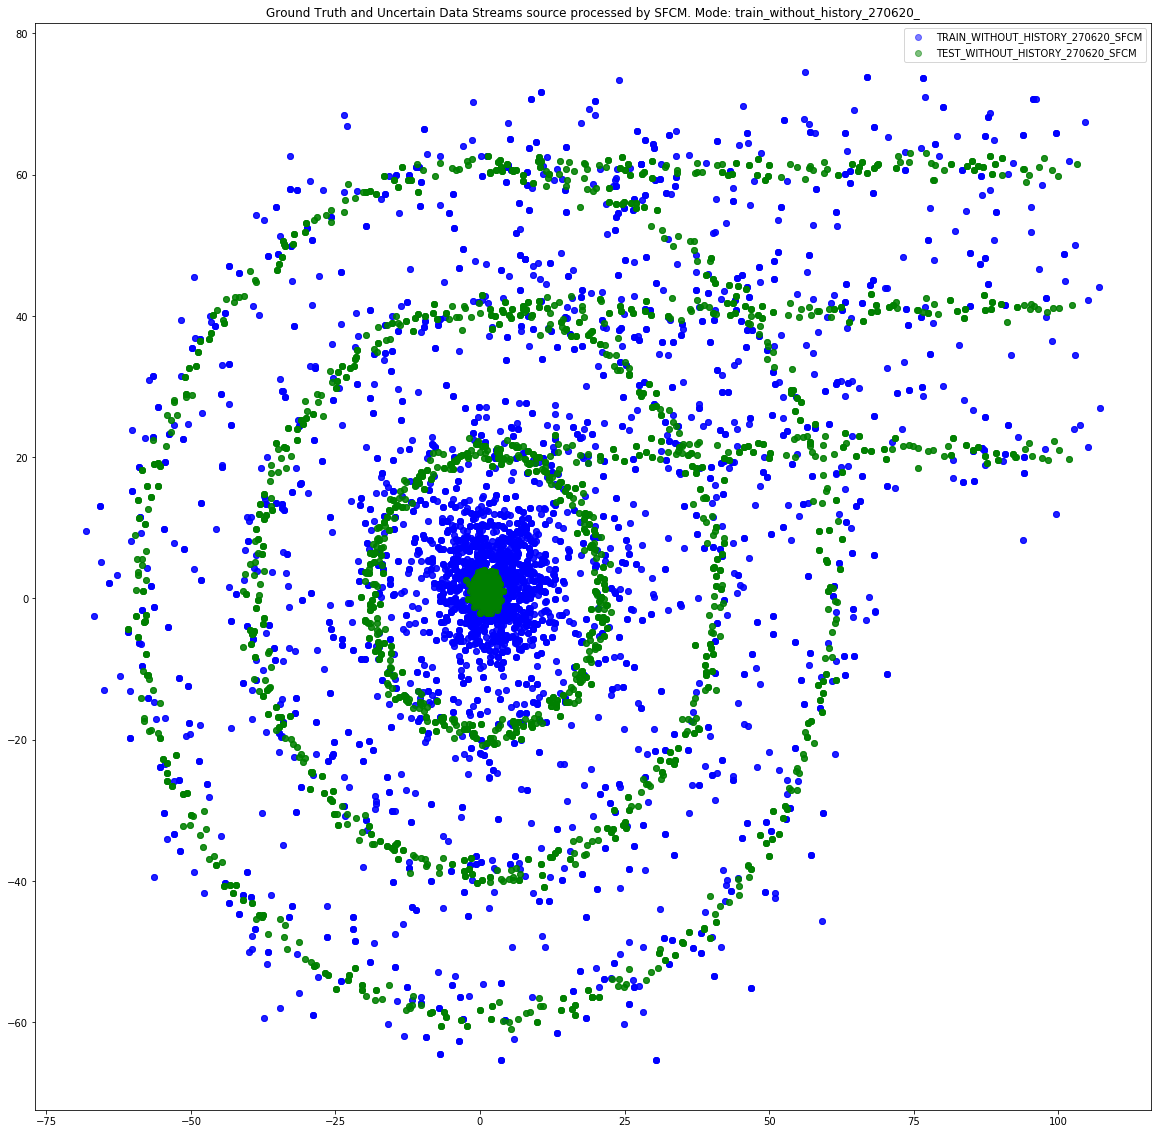

In [178]:
# Prepare layout

fig, ax = plt.subplots(figsize=(20,20))

## Draw data points
x_train = np.stack(df_train["data_point"].values)[:,0]
y_train = np.stack(df_train["data_point"].values)[:,1]
#train_membership=df_train["data_point_membership"].fillna(0).astype(np.float)
#train_color = df_train.reset_index()["timestamp"].map(lambda x: train_cmap(train_time_normalizer(train_timestamp_enum[x])))

x_test = np.stack(df_test["data_point"].values)[:,0]
y_test = np.stack(df_test["data_point"].values)[:,1]
#test_membership=df_train["data_point_membership"].fillna(0).astype(np.float)
#test_color = df_test.reset_index()["timestamp"].map(lambda x: test_cmap(test_time_normalizer(test_timestamp_enum[x])))

ax.scatter(x_train,y_train, alpha=0.5, c="blue",label=f"{TRAIN_ALGORITHM_PREFIX_NAME.upper()}");
ax.scatter(x_test, y_test, alpha=0.5, c="green", label=f"{TEST_ALGORITHM_PREFIX_NAME.upper()}");
plt.title(f"Ground Truth and Uncertain Data Streams source processed by {ALGORITHM.upper()}. Mode: {ALGO_TRAIN_PREFIX}")
plt.legend();

In [179]:
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_data_stream_{current_time}.pdf")
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_data_stream_{current_time}.png")

In [180]:
pd.pivot_table(df_train, index=["timestamp","data_point_unique_id","cluster_label"],values="data_point_membership" )

data_point_membership
timestamp               data_point_unique_id      cluster_label                       
2020-07-08 00:56:10.833 [ 0.09729845 13.11145982] 1                           0.001560
                                                  3                           0.035261
                                                  4                           0.946581
                        [ 1.01827568 12.59573285] 1                           0.002986
                                                  3                           0.092229
...                                                                                ...
2020-07-08 00:58:25.746 [68.32790866 -1.76726148] 3                           0.001927
                                                  4                           0.997161
                        [68.37829206 -1.8493667 ] 1                           0.000113
                                                  3                           0.002091
                                                  4                           0.996944

[10680 rows x 1 columns]

In [181]:
# Calculate summarized weights for clusters over time range
def calculate_cluster_weights(df):
    
    cluster_weights = df.groupby(["cluster_label"]).apply(lambda x: x["data_point_membership"].sum() / len(x))

    return np.stack(list(enumerate(cluster_weights)))

calculate_cluster_weights(df_train)

array([[0.        , 0.20127312],
       [1.        , 0.21134722],
       [2.        , 0.16395614]])

In [182]:
calculate_cluster_weights(df_test)

array([[0.        , 0.21805375],
       [1.        , 0.19624081],
       [2.        , 0.16855787]])

## Modified F1-Score

In [183]:
# Modified F1-Score for Fuzzy Clusters
# Let's we have a predicted result for a timestamp T
# We expect here is N data points with C clusters
# Therefore, the input structure will be: (N,C)
#
# If we have 50 data points with 3 clusters, then
# - Sum of weights for a fuzzy cluster j: \sum_{i=1}^{|N|} w_{ij} -> (C,)


def f1_fuzzy(left_df, right_df):
    
    _l = pd.pivot_table(left_df, index=["data_point_unique_id"], columns="cluster_label", values="data_point_membership" ).fillna(0)
    _r = pd.pivot_table(right_df, index=["data_point_unique_id"], columns="cluster_label", values="data_point_membership" ).fillna(0)
    
    _l_fuzzy_clusters_weights = calculate_cluster_weights(left_df)
    _r_fuzzy_clusters_weights = calculate_cluster_weights(right_df)
    
    # Trunkate _l and _r to the minimum size
    min_length = min(len(_l),len(_r))
    
    
    diff = 1 - np.sqrt(np.power((np.array(_l[:min_length]) - np.array(_r[:min_length])),2))
    
    # calculate clusters precision
    precision_by_clusters = (diff / _l_fuzzy_clusters_weights[:,1])
    # calculate clusters recall
    recall_by_clusters = (diff / _r_fuzzy_clusters_weights[:,1])
    
    # calculate f1 score for each point
    f1_score = np.nan_to_num( 2 * (precision_by_clusters * recall_by_clusters) / (precision_by_clusters + recall_by_clusters))
    
    # calculate overall f1 score
    f1_score_overall = np.sum(_r_fuzzy_clusters_weights[:,1]/len(_r_fuzzy_clusters_weights) * np.max(f1_score,0) / np.sum(_r_fuzzy_clusters_weights[:,1]) )
    
    return diff, precision_by_clusters, recall_by_clusters, f1_score, f1_score_overall


_,_,_,_,f1 = f1_fuzzy(df_train, df_test)

In [184]:
print("Overall F1 score:", f1)

Overall F1 score: 1.725303794425936


In [185]:
min_length = min(len(df_train), len(df_test)) 


window = 10

f1_dynamic = []

for i in range(0,min_length, window):
    r = i + window
    
    train = df_train.iloc[i:r]
    test = df_test.iloc[i:r]
    
    if len(train) != len(test):
        continue
    
    try:
        _,_,_,f1_components,f1 = f1_fuzzy(train, test)
    except ValueError as e:
        print(f"Different number of clusters,slices: {i}:{r}! Set current f1_score to -1")
        f1_dynamic.append(-1)
    else:    
        f1_dynamic.append(f1)

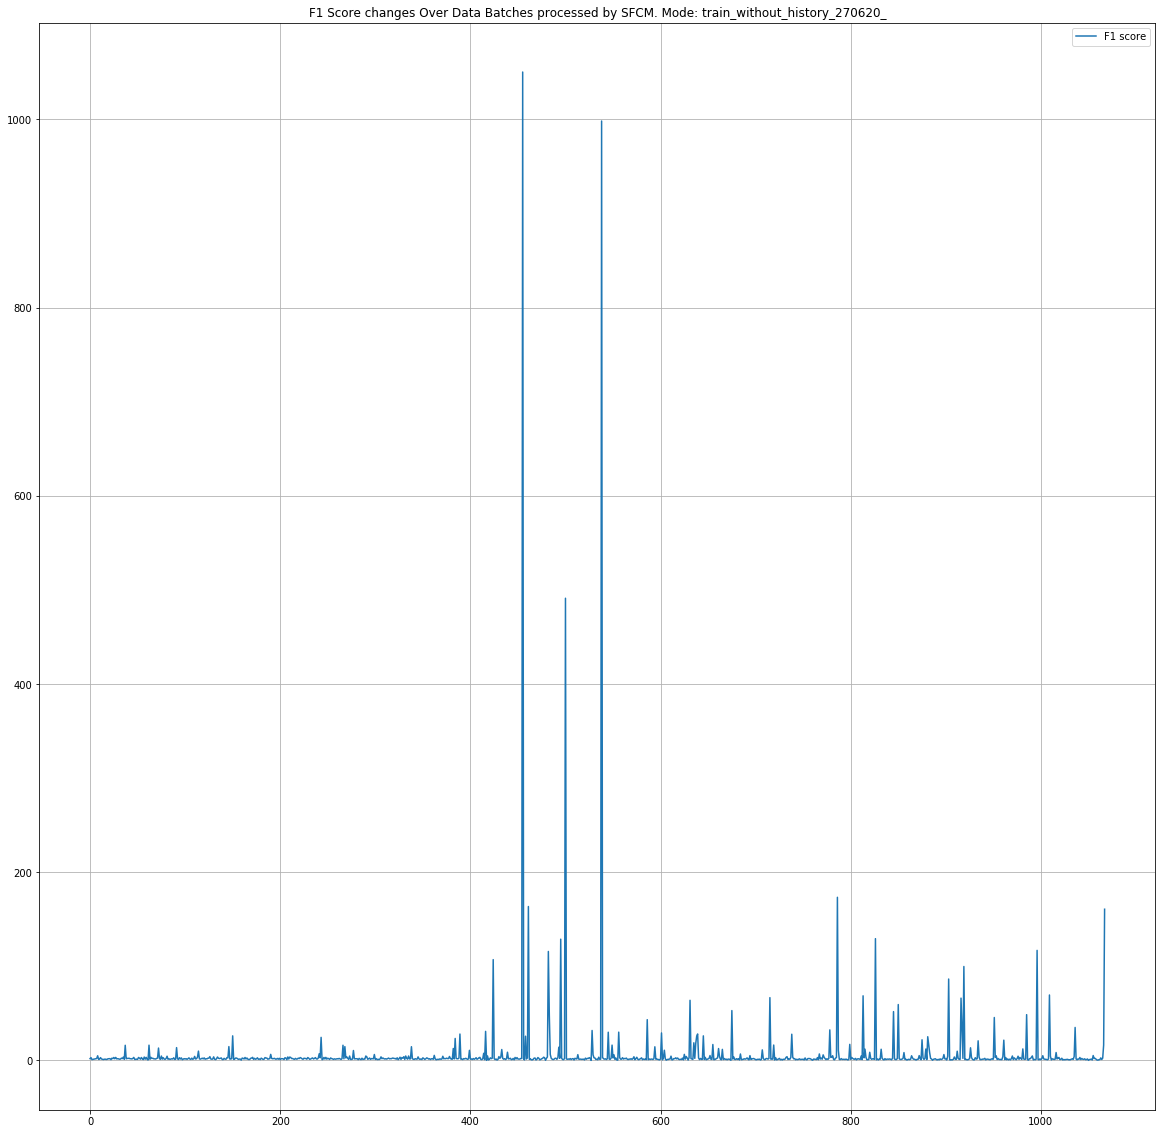

In [186]:
#Calculate over timestamps

fig, ax = plt.subplots(figsize=(20,20))

ax.plot(f1_dynamic, label="F1 score")
plt.legend()
plt.grid()
plt.title(f"F1 Score changes Over Data Batches processed by {ALGORITHM.upper()}. Mode: {ALGO_TRAIN_PREFIX}");

In [187]:
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_f1_score_changes_{current_time}.pdf")
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_f1_score_changes_{current_time}.png")

## Fuzzy Silhouette

In [188]:
# Silhouette

df = df_train[["data_point","cluster_label","data_point_membership"]]

cluster_weights = calculate_cluster_weights(df)

In [189]:
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import pairwise_distances


In [190]:
def get_unique_data_points(local_df):
        
    unique_data_points = local_df[["data_point_unique_id","data_point"]].groupby("data_point_unique_id").apply(lambda x: x.iloc[-1])
    
    cluster_label_with_highest_membership = local_df[["data_point_unique_id","cluster_label","data_point_membership"]]
    
    def get_index_of_max_membership_cluster(piece):
        
        memberships = np.array(piece["data_point_membership"])
        
        max_index = np.argmax(memberships)
        
        max_cluster_label = np.array(df["cluster_label"])[max_index]
        
        return max_cluster_label
        
    unique_data_points_labels = cluster_label_with_highest_membership.groupby("data_point_unique_id").apply(get_index_of_max_membership_cluster)
    
    unique_data_points["cluster_label"] = unique_data_points_labels
    
    return unique_data_points



def first_second_membership_diff(local_df):
    
    data_points = local_df[["data_point_unique_id","cluster_label","data_point_membership"]]
     
    def get_difference_func(piece):
        
        memberships = np.sort(np.unique(np.array(piece["data_point_membership"])))
        
        difference = 0
        
        if len(memberships)>=2:
            difference= memberships[-1] - memberships[-2] 
        elif len(memberships) == 1:
            difference= memberships[0]
        else:
            difference=0
            
        return pd.Series(difference, name="difference")
        
    membership_difference = local_df.groupby(["data_point_unique_id","cluster_label"])\
        .apply(get_difference_func)
    
    foo = pd.DataFrame(membership_difference)
    
    final = pd.pivot(foo.reset_index(), index="data_point_unique_id", columns="cluster_label",values=0).fillna(0)
    
    return  final




def calculate_fuzzy_silhouette_score(local_df, a=1):
    
    unique_points_from_fuzzy_set = get_unique_data_points(local_df)
    membership_difference = first_second_membership_diff(local_df)
    points = np.stack(unique_points_from_fuzzy_set["data_point"])
    
    unique_cluster_labels = local_df["cluster_label"].unique()
    
    # Then iterate over each fuzzy_cluster:
    silhouette_components = []
    
    for expected_cluster_label in unique_cluster_labels:
        
        labels = unique_points_from_fuzzy_set["cluster_label"] == expected_cluster_label
        
        if len(np.unique(labels))>1:
            
            diff_powered = membership_difference[expected_cluster_label].pow(a)
        
            s = silhouette_samples(points, labels)
        
            silhouette_components.append((diff_powered * s).sum() / diff_powered.sum())
            
        else:
            # Cluster contains only singleton values
            silhouette_components.append(0)
        
    foo = np.array(silhouette_components)
    
    return foo, np.sum(foo)


silh_train = calculate_fuzzy_silhouette_score(df_train)
silh_test = calculate_fuzzy_silhouette_score(df_test)

In [191]:
print("Fuzzy Silhouette for Train:", silh_train[-1])
print("Fuzzy Silhouette for Test:", silh_test[-1])

Fuzzy Silhouette for Train: 0.08027096716211929
Fuzzy Silhouette for Test: 0.035398215723327374


In [192]:

# Let's try to calculate for several timestamps

silhouette_train_dynamic = df_train.groupby("timestamp").apply(lambda x: calculate_fuzzy_silhouette_score(x)[-1])
silhouette_test_dynamic = df_test.groupby("timestamp").apply(lambda x: calculate_fuzzy_silhouette_score(x)[-1])

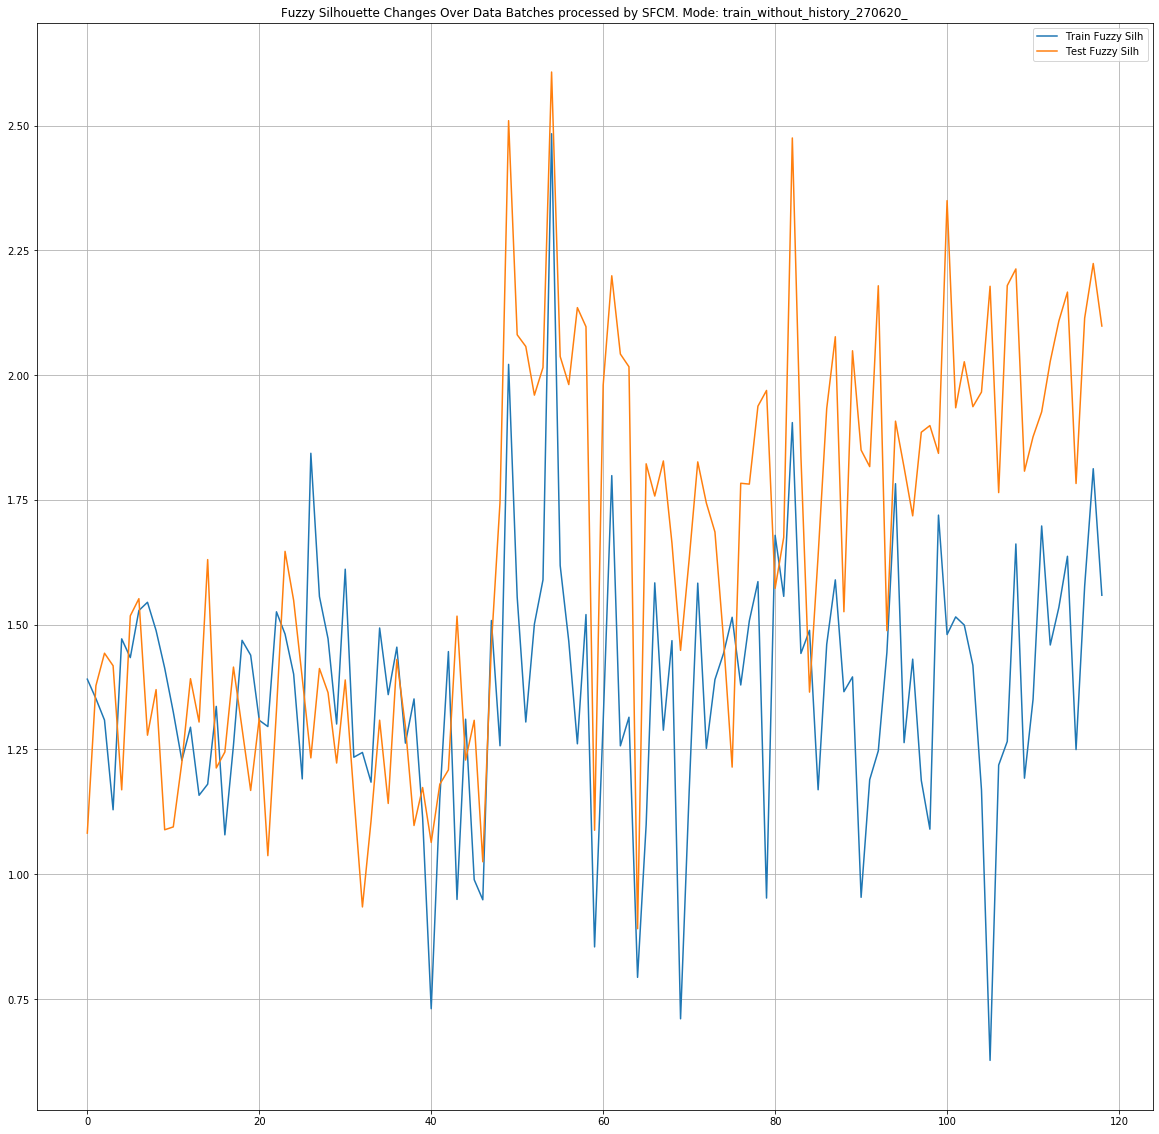

In [193]:
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(silhouette_train_dynamic.values,label="Train Fuzzy Silh")
ax.plot(silhouette_test_dynamic.values, label="Test Fuzzy Silh")
plt.grid()
plt.title(f"Fuzzy Silhouette Changes Over Data Batches processed by {ALGORITHM.upper()}. Mode: {ALGO_TRAIN_PREFIX}")
plt.legend();

In [194]:
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_Fuzzy_Silh_score_changes_{current_time}.pdf")
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_Fuzzy_Silh_score_changes_{current_time}.png")

## Fuzzy hypervolume

The less the value the better


In [195]:
def calculate_fuzzy_covariance_matrix(df):
    diff = np.stack(df["data_point"]) - np.stack(df["centroid"])
    total_cluster_membership = df["data_point_membership"].sum()
    memberships=df["data_point_membership"]
    
    foo = np.stack([(m * v) for m, v in zip(memberships, np.dot(diff.T,diff)) ])

    
    return foo / total_cluster_membership


def calculate_fuzzy_hypervolume(df):
    
    fuzzy_covariance_matrix_elements = df.groupby("cluster_label").apply(calculate_fuzzy_covariance_matrix)
    
    return fuzzy_covariance_matrix_elements.map(lambda x: np.sqrt(np.linalg.det(x)) ).sum()


In [196]:
# First, calculate for overall datasets
fhv_train_overall = calculate_fuzzy_hypervolume(df_train)
fhv_test_overall = calculate_fuzzy_hypervolume(df_test)

In [197]:
print(f"Overall Fuzzy Hypervolume for Train: {fhv_train_overall}")
print(f"Overall Fuzzy Hypervolume for Test: {fhv_test_overall}")

Overall Fuzzy Hypervolume for Train: 50.06663868431586
Overall Fuzzy Hypervolume for Test: 80.46965958736104


In [198]:
# Calculate over data stream timestamps

fvh_train_dynamic = df_train.groupby("timestamp").apply(calculate_fuzzy_hypervolume)
fvh_test_dynamic = df_test.groupby("timestamp").apply(calculate_fuzzy_hypervolume)


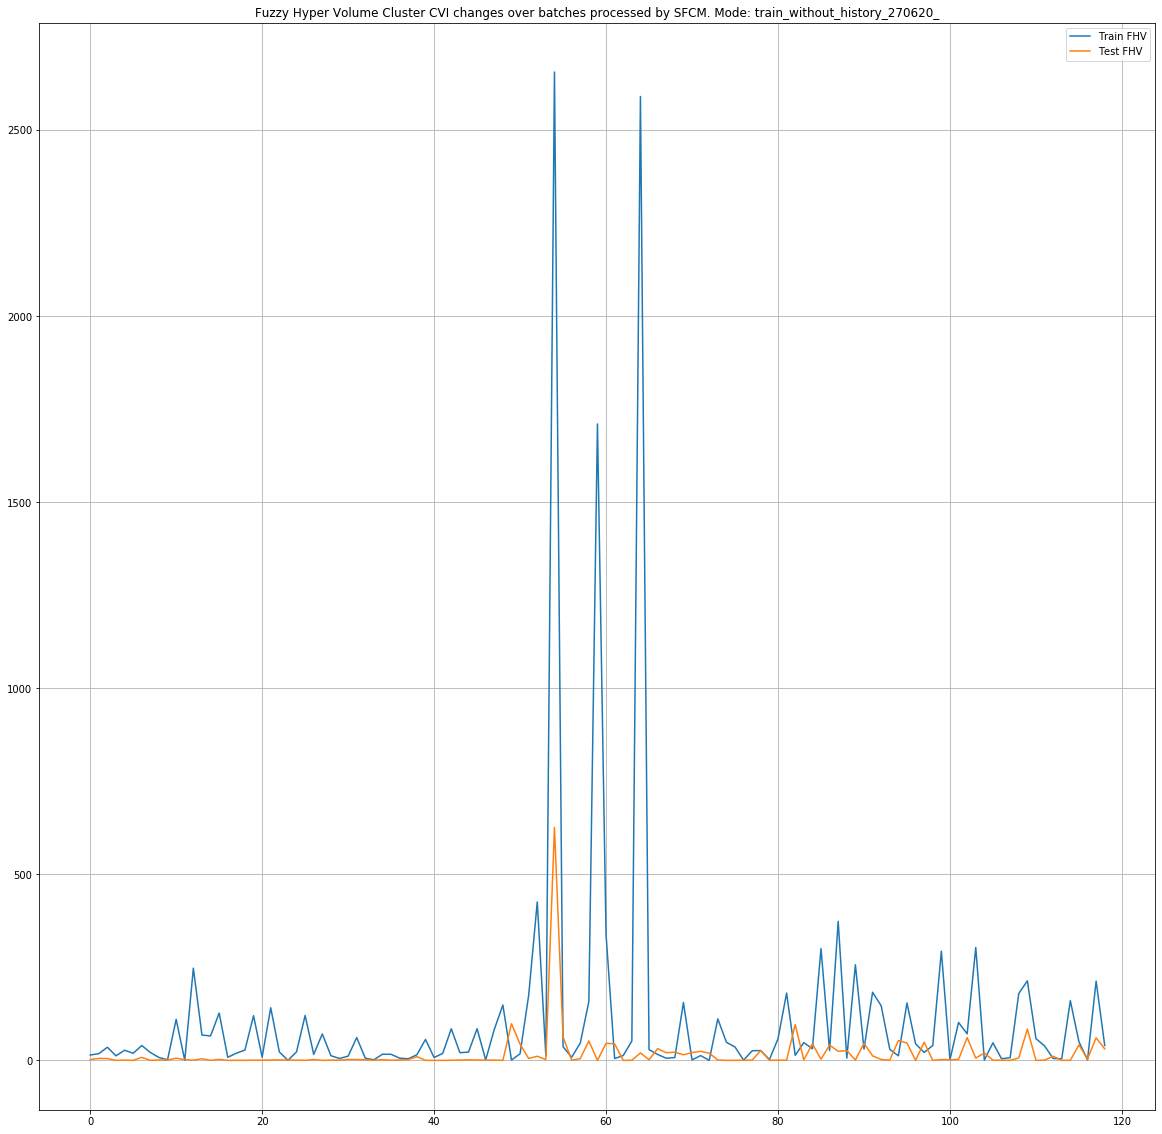

In [199]:
fig, ax = plt.subplots(figsize=(20,20))

train_fsilh_plt = ax.plot(fvh_train_dynamic.values,label="Train FHV")
test_fsilh_plt = ax.plot(fvh_test_dynamic.values, label="Test FHV")
plt.legend()
plt.grid()
plt.title(f"Fuzzy Hyper Volume Cluster CVI changes over batches processed by {ALGORITHM.upper()}. Mode: {ALGO_TRAIN_PREFIX}");

In [200]:
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_FHV_score_changes_{current_time}.pdf")
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_FHV_score_changes_{current_time}.png")

## Average Partition Density


The larger value the better

In [201]:
def calculate_sum_of_central_members(df):
    
    diff = np.stack(df["data_point"]) - np.stack(df["centroid"])
    total_cluster_membership = df["data_point_membership"].sum()
    memberships=df["data_point_membership"]
    
    fuzzy_covariance_matrix = np.stack([(m * v) for m, v in zip(memberships, np.dot(diff.T,diff)) ]) / total_cluster_membership
    
    
    def check_condition(x):
        is_added = False
        try:
            is_added = np.dot(np.dot(np.linalg.inv(fuzzy_covariance_matrix),x.T),x) <1
        except numpy.linalg.LinAlgError as e:
            # Singular matrix appear in Inverse matrix
            # Cannot find inverse
            pass
        finally:
            return is_added
            
            
        
    
    count_bool = np.apply_along_axis(check_condition,axis=1, arr=diff)
    
    memberships[count_bool]
    
    
    return memberships[count_bool].sum()

In [202]:
def calculate_average_partition_density(df):
    
    R = df.groupby("cluster_label").apply(calculate_sum_of_central_members)
    
    fuzzy_covariance_matrix_elements = df.groupby("cluster_label").apply(calculate_fuzzy_covariance_matrix)
    
    number_of_clusters = len(df["cluster_label"].unique())
    
    
    return np.sum(list(map(lambda x:x[1]/ np.sqrt(np.linalg.det(x[0]) ), zip(fuzzy_covariance_matrix_elements,R)))) / number_of_clusters  

In [203]:
# Calculate overall APD

APD_train_overall = calculate_average_partition_density(df_train)
APD_test_overall = calculate_average_partition_density(df_test)

In [204]:
print(f"Overall Average Partition Density for Train: {APD_train_overall}")
print(f"Overall Average Partition Density for Test: {APD_test_overall}")

Overall Average Partition Density for Train: 7.337716901946294
Overall Average Partition Density for Test: 24.125655283384457


In [205]:
# Calculate over data stream timestamps

APD_train_dynamic = df_train.groupby("timestamp").apply(calculate_average_partition_density)
APD_test_dynamic = df_test.groupby("timestamp").apply(calculate_average_partition_density)


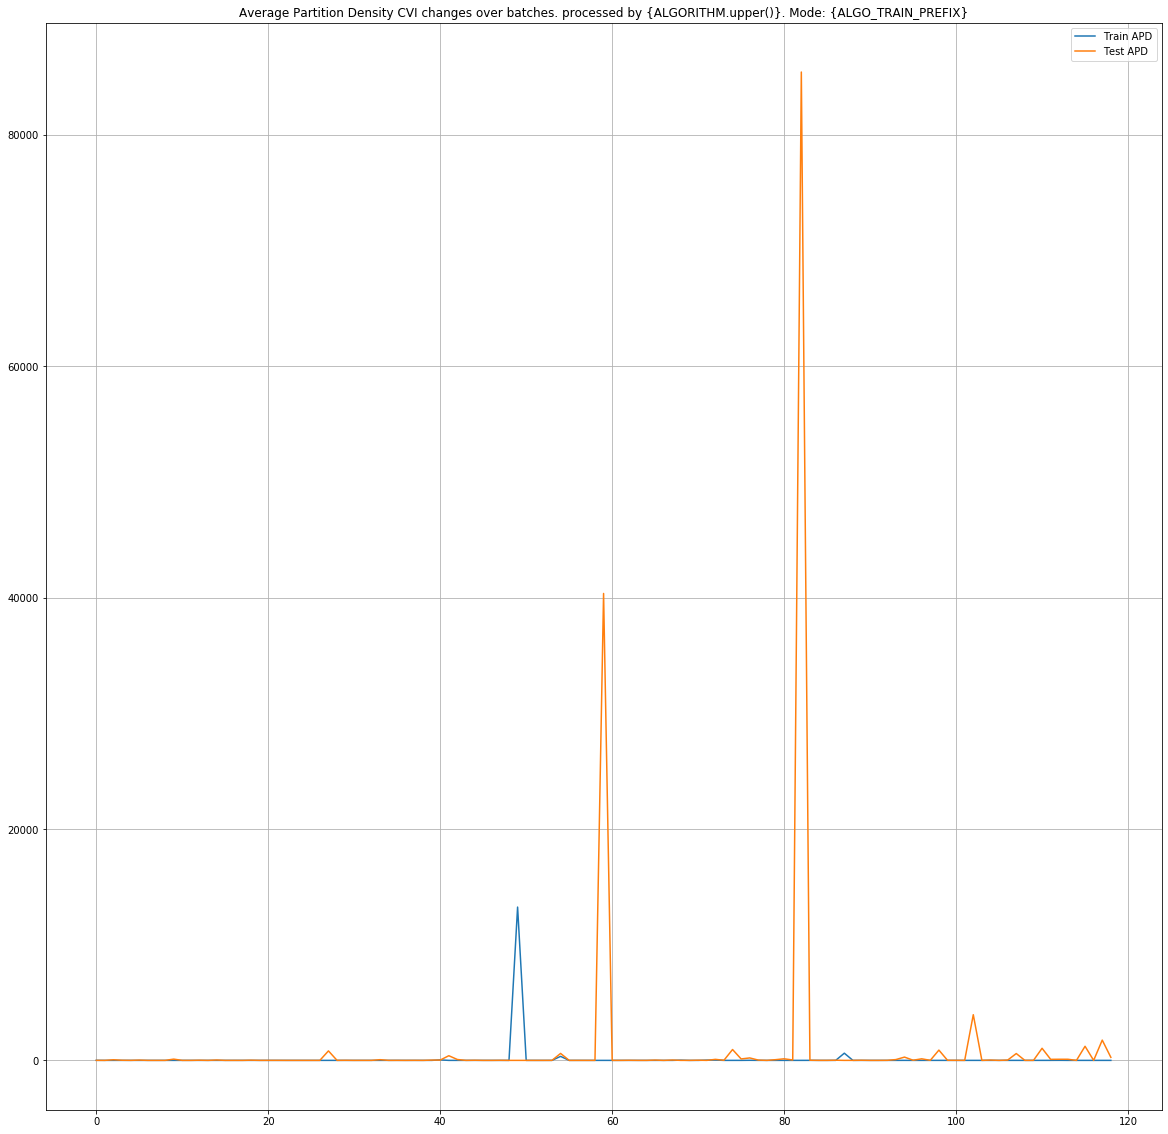

In [206]:
fig, ax = plt.subplots(figsize=(20,20))
train_fsilh_plt = ax.plot(APD_train_dynamic.values,label="Train APD")
test_fsilh_plt = ax.plot(APD_test_dynamic.values, label="Test APD")
plt.legend()
plt.grid()
plt.title("Average Partition Density CVI changes over batches. processed by {ALGORITHM.upper()}. Mode: {ALGO_TRAIN_PREFIX}");

In [207]:
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_APD_score_changes_{current_time}.pdf")
fig.savefig(f"images/analysis_{ALGORITHM}-{ALGO_TRAIN_PREFIX}_APD_score_changes_{current_time}.png")